<span style ="font-size:35px;"> **Operações e Serviços** </span> 

<span style ="font-size:30px;"> **Binary Classification for Customer Satisfaction** </span> <div>

### **Logistic Regression Model (13 variables)**
***


### **Libraries**
***

In [132]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegressio
import seaborn as sns
import matplotlib.pyplot as plt
import time



### **Loading the data** 
***

In [125]:
# Carregar os dados de treino e teste de sheets diferentes
train_data = pd.read_excel('C:/Users/USER/Downloads/Passanger_Satisfaction_survey_dataset_GRUPO.xlsx', 
                           sheet_name='Train_Passenger_Satisfaction_Dt')

test_data = pd.read_excel('C:/Users/USER/Downloads/Passanger_Satisfaction_survey_dataset_GRUPO.xlsx', 
                          sheet_name='Test_Passenger_Satisfaction_Dt')

# Identificar a coluna target
target_column = 'satisfaction_v2'

# Separar features e target no conjunto de treino
X_train = train_data.drop(columns=[target_column])  # Todas as colunas exceto o target
y_train = train_data[target_column]  # Apenas o target

# Separar features e target no conjunto de teste
X_test = test_data.drop(columns=[target_column])  # Todas as colunas exceto o target
y_test = test_data[target_column]  # Apenas o target

# Filtrar apenas as colunas normalizadas no conjunto de treino e teste
normalized_columns = [col for col in X_train.columns if col.startswith('normalized_')]

# Remover variáveis específicas
vars_to_remove = [
    'normalized_Age', 
    'normalized_Gender', 
    'normalized_Flight Distance', 
    'normalized_Departure/Arrival time convenient', 
    'normalized_Gate location', 
    'normalized_Arrival Delay in Minutes', 
    'normalized_Departure Delay in Minutes',
    'normalized_Type of Travel', 
    'normalized_Food and drink',
    'normalized_satisfaction_v2'
]
normalized_columns = [col for col in normalized_columns if col not in vars_to_remove]

X_train_normalized = X_train[normalized_columns]
X_test_normalized = X_test[normalized_columns]

# Converter para NumPy arrays
X_train_array = X_train_normalized.to_numpy()
X_test_array = X_test_normalized.to_numpy()
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

# Verificar os shapes
print("Shape de X_train_array:", X_train_array.shape)
print("Shape de X_test_array:", X_test_array.shape)
print("Shape de y_train_array:", y_train_array.shape)
print("Shape de y_test_array:", y_test_array.shape)

# Verificar os 10 primeiros exemplos no formato NumPy
print("Primeiros 10 exemplos de X_train_array:")
print(X_train_array[:10])
print("Primeiros 10 valores de y_train_array:")
print(y_train_array[:10])



Shape de X_train_array: (103589, 13)
Shape de X_test_array: (25898, 13)
Shape de y_train_array: (103589,)
Shape de y_test_array: (25898,)
Primeiros 10 exemplos de X_train_array:
[[0.   1.   0.6  1.   0.6  1.   1.   0.6  0.4  1.   0.8  1.   1.  ]
 [1.   1.   0.4  0.8  0.8  1.   1.   1.   1.   1.   0.6  1.   0.8 ]
 [1.   1.   0.6  0.8  1.   0.8  0.6  0.6  0.8  0.5  0.6  0.6  1.  ]
 [1.   1.   0.8  0.6  1.   0.8  0.8  0.8  0.8  0.75 0.6  0.8  0.6 ]
 [1.   1.   0.6  1.   0.8  1.   1.   1.   1.   1.   0.8  1.   0.8 ]
 [1.   1.   0.8  0.8  0.8  0.8  0.6  0.6  0.8  0.5  0.6  0.6  0.8 ]
 [1.   1.   0.8  0.6  0.4  0.6  0.8  0.8  0.8  0.75 0.6  0.8  0.6 ]
 [1.   1.   0.4  0.4  1.   0.8  1.   1.   1.   1.   0.6  1.   0.8 ]
 [0.   1.   0.2  0.4  0.2  0.4  0.4  0.4  1.   0.5  0.6  0.8  0.4 ]
 [0.   1.   0.2  0.2  0.4  0.4  0.2  0.4  1.   0.75 0.2  0.6  0.2 ]]
Primeiros 10 valores de y_train_array:
[0 1 1 1 1 1 0 1 0 0]


### **Sigmoid function**
***

In [4]:
def sigmoid(z):

    g = 1/(1+np.exp(-z))
   
    return g

### **Cost Function**
***

In [5]:
def compute_cost_logistic(X, y, w, b):
    m,n  = X.shape
    cost = 0.
    for i in range(m):
        z_i = np.dot(X[i], w) + b                                      #(n,)(n,)=scalar, see np.dot
        f_wb_i = sigmoid(z_i)                                          #scalar
        cost +=  -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)      #scalar
             
    cost = cost/m                                                      #scalar

    return cost  

### **Logistic Gradient Descent**
***

In [29]:
def compute_gradient_logistic(X, y, w, b): 
    m,n = X.shape
    dj_dw = np.zeros((n,))                            #(n,)
    dj_db = 0.0                                       #scalar

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          #(n,)(n,)=scalar
        err_i  = f_wb_i  - y[i]                       #scalar
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      #scalar
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   #(n,)
    dj_db = dj_db/m                                   #scalar


    return dj_db, dj_dw  

def gradient_descent(X, y, w_in, b_in, alpha, num_iters):
    J_history = []
    accuracies = []  # Histórico da precisão
    precisions = []
    w = copy.deepcopy(w_in)
    b = b_in

    for i in range(num_iters):
        dj_db, dj_dw = compute_gradient_logistic(X, y, w, b)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        J_history.append(compute_cost_logistic(X, y, w, b))
        
        if i % 100 == 0:
            y_pred = sigmoid(np.dot(X, w) + b) >= 0.5  # Predição binária
            accuracy = np.mean(y_pred == y)  # Comparar predições com o target
            precision = precision_score(y, y_pred)  # Calcular precisão
            accuracies.append(accuracy)
            precisions.append(precision)
            print(f"Iteration {i:4d}: Cost {J_history[-1]:.10f}, Accuracy {accuracy:.10f}, Precision {precision:.10f}")
    
    return w, b, J_history, accuracies, precisions
        

In [37]:
# Configurações do modelo
w_tmp = np.zeros_like(X_train_array[0])  # Pesos iniciais
b_tmp = 0.0  # Bias inicial
alpha = 0.1  # Taxa de aprendizado
iters = 3200  # Número de iterações

# Medir o tempo de execução
start_time = time.time()  # Registrar o tempo inicial

# Treinamento do modelo
w_out, b_out, J_history, accuracies, precisions = gradient_descent(
    X_train_array, y_train_array, w_tmp, b_tmp, alpha, iters
)

end_time = time.time()  # Registrar o tempo final

# Calcular o tempo total de execução
elapsed_time = end_time - start_time

# Exibir os parâmetros finais
print(f"\nUpdated parameters: w:{w_out}, b:{b_out}")

# Exibir o último valor de Accuracy e Precision
final_accuracy = accuracies[-1] if accuracies else None
final_precision = precisions[-1] if precisions else None

print(f"Final Accuracy: {final_accuracy:.4f}")
print(f"Final Precision: {final_precision:.4f}")

# Exibir o tempo total de execução
print(f"Elapsed Time for Training: {elapsed_time:.2f} seconds")

Iteration    0: Cost 0.6855275186, Accuracy 0.5470175405, Precision 0.5470175405
Iteration  100: Cost 0.6212297347, Accuracy 0.6162719980, Precision 0.5897471269
Iteration  200: Cost 0.5875345019, Accuracy 0.7024104876, Precision 0.6606361285
Iteration  300: Cost 0.5625069466, Accuracy 0.7379644557, Precision 0.6991029878
Iteration  400: Cost 0.5428405244, Accuracy 0.7533811505, Precision 0.7187833961
Iteration  500: Cost 0.5268801959, Accuracy 0.7642896447, Precision 0.7330866196
Iteration  600: Cost 0.5136708430, Accuracy 0.7744065490, Precision 0.7462649034
Iteration  700: Cost 0.5025913768, Accuracy 0.7818880383, Precision 0.7568565958
Iteration  800: Cost 0.4932035035, Accuracy 0.7876898126, Precision 0.7657672850
Iteration  900: Cost 0.4851819313, Accuracy 0.7924007375, Precision 0.7731680030
Iteration 1000: Cost 0.4782777076, Accuracy 0.7955381363, Precision 0.7786853059
Iteration 1100: Cost 0.4722964808, Accuracy 0.7981156300, Precision 0.7832335140
Iteration 1200: Cost 0.46708

### **Variables Impact**
***


Impacto das Features:
                              Feature    Weight  Absolute Weight
4   normalized_Inflight entertainment  2.837868         2.837868
6   normalized_Ease of Online booking  1.689465         1.689465
7         normalized_On-board service  1.049725         1.049725
0            normalized_Customer Type  0.924312         0.924312
1                    normalized_Class  0.889003         0.889003
3    normalized_Inflight wifi service  0.701040         0.701040
8         normalized_Leg room service  0.697814         0.697814
10         normalized_Checkin service  0.670986         0.670986
5           normalized_Online support  0.550907         0.550907
12         normalized_Online boarding  0.349158         0.349158
9         normalized_Baggage handling  0.324061         0.324061
11             normalized_Cleanliness  0.289587         0.289587
2             normalized_Seat comfort  0.269425         0.269425


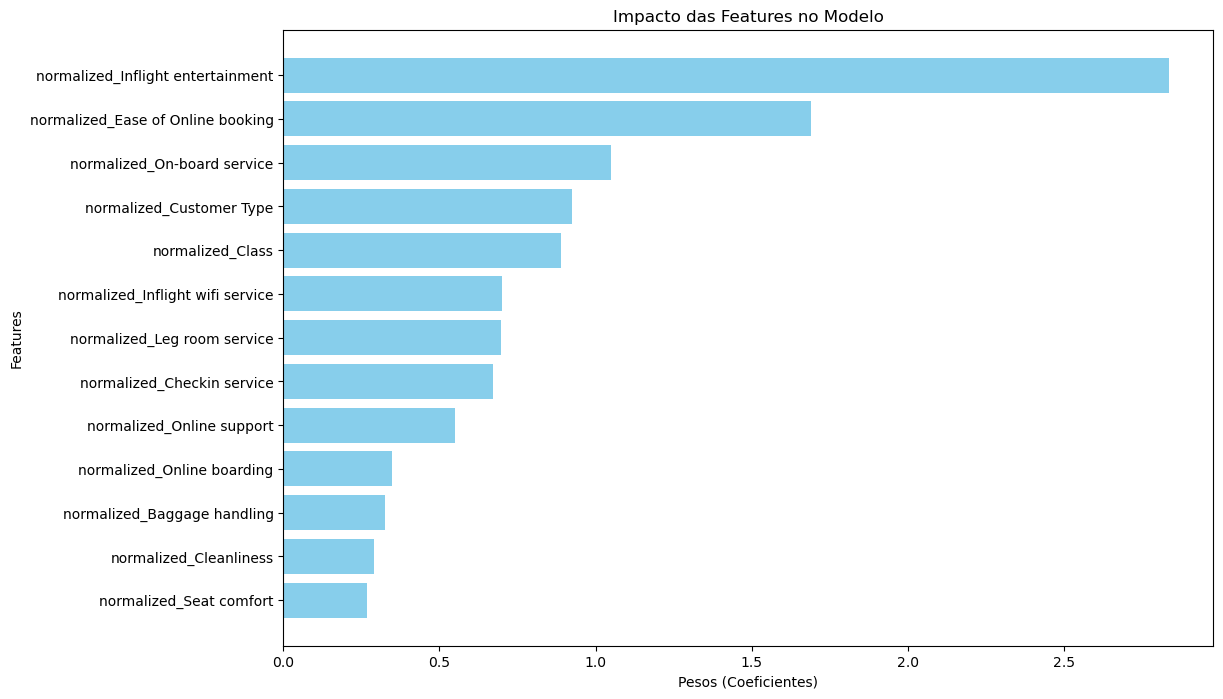

In [95]:
# Ajustar o impacto das features para valores absolutos
adjusted_weights = np.abs(w_out)  # Torna todos os valores absolutos

# Criar a tabela ajustada
adjusted_feature_impact = pd.DataFrame({
    "Feature": normalized_columns,
    "Weight": adjusted_weights
})

# Ordenar pelo impacto absoluto
adjusted_feature_impact["Absolute Weight"] = adjusted_feature_impact["Weight"]
adjusted_feature_impact = adjusted_feature_impact.sort_values(
    by="Absolute Weight", ascending=False
)

# Exibir o impacto ajustado
print("\nImpacto das Features:")
print(adjusted_feature_impact)

# Plotar impacto ajustado das features
plt.figure(figsize=(12, 8))
plt.barh(adjusted_feature_impact["Feature"], adjusted_feature_impact["Weight"], color="skyblue")
plt.xlabel("Pesos (Coeficientes)")
plt.ylabel("Features")
plt.title("Impacto das Features no Modelo")
plt.gca().invert_yaxis()  # Inverter ordem para maior impacto no topo
plt.show()


### **Model Evolution**
***

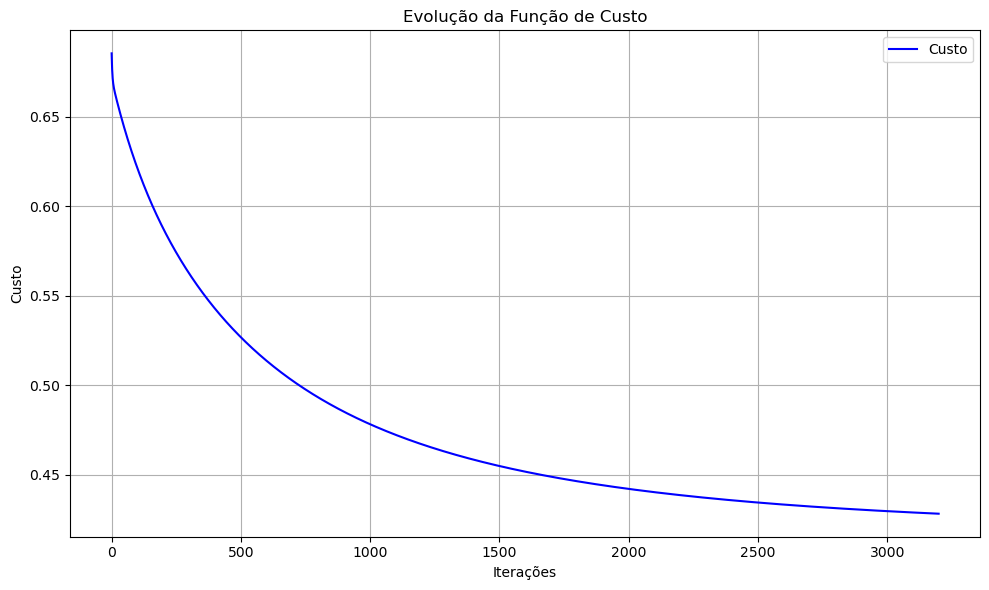

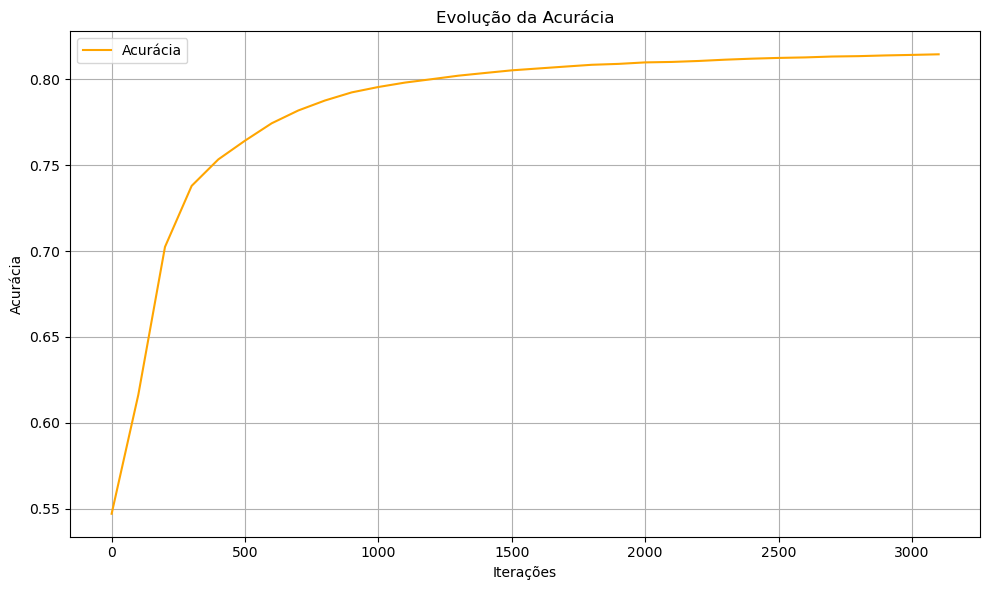

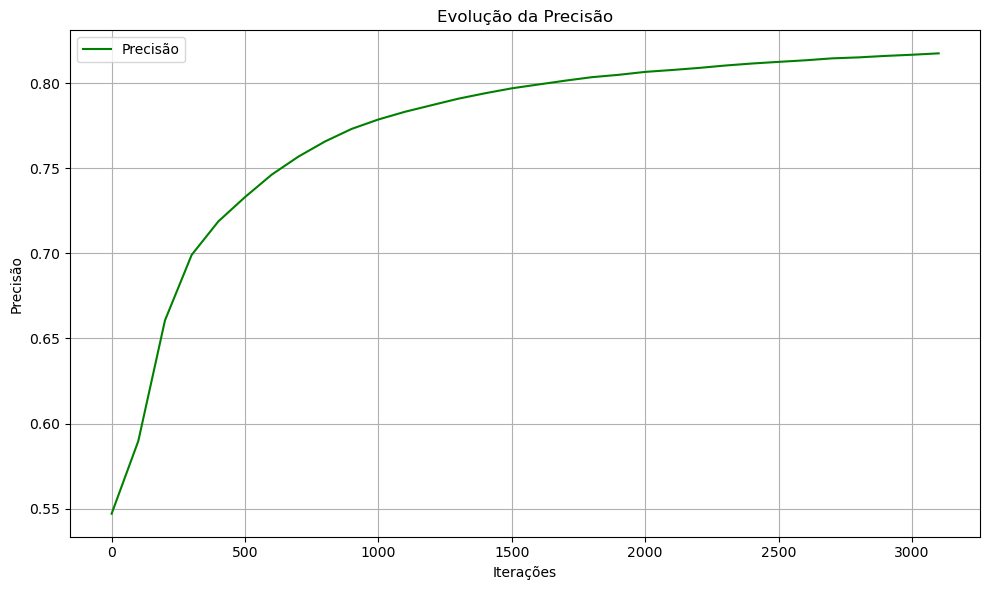

In [33]:
# Plotar evolução da função de custo
plt.figure(figsize=(10, 6))
plt.plot(range(len(J_history)), J_history, label='Custo', color='blue')
plt.xlabel('Iterações')
plt.ylabel('Custo')
plt.title('Evolução da Função de Custo')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotar evolução da acurácia
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(accuracies) * 100, 100), accuracies, label='Acurácia', color='orange')
plt.xlabel('Iterações')
plt.ylabel('Acurácia')
plt.title('Evolução da Acurácia')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotar evolução da precisão
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(precisions) * 100, 100), precisions, label='Precisão', color='green')
plt.xlabel('Iterações')
plt.ylabel('Precisão')
plt.title('Evolução da Precisão')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### **Predictions | test data** 
***

In [133]:
# Criar as variáveis de saída (pesos) para não precisar treinar novamente
w_out = np.array([0.92431188, 0.88900266, 0.26942487, -0.70104003, 2.83786787, 
                  0.55090698, 1.6894654, 1.04972461, 0.6978139, 0.32406121, 
                  0.67098558, -0.28958675, 0.34915844])

b_out = -5.988469302116979

# Função para prever valores
def predict(X, w, b):
    z = np.dot(X, w) + b  # Calcular z
    y_pred = sigmoid(np.dot(X, w) + b)  # Aplicar sigmoid
    return np.where(y_pred >= 0.5, 1, 0)  # Converter para 0 ou 1 (threshold 0.5)

# Previsões no conjunto de teste
y_test_pred = predict(X_test_array, w_out, b_out)

# Exibir as primeiras 10 previsões e os valores reais correspondentes
print("Primeiras 10 previsões do conjunto de teste:", y_test_pred[:10])
print("Primeiros 10 valores reais do conjunto de teste:", y_test_array[:10])
print("Shape das previsões:", y_test_pred.shape)
print("Shape dos valores reais:", y_test_array.shape)


Primeiras 10 previsões do conjunto de teste: [1 1 1 1 0 1 1 1 1 1]
Primeiros 10 valores reais do conjunto de teste: [1 1 1 1 1 1 1 1 1 1]
Shape das previsões: (25898,)
Shape dos valores reais: (25898,)


### **Model Evaluation**
***

In [130]:
precision = precision_score(y_test_array, y_test_pred)
accuracy = accuracy_score(y_test_array, y_test_pred)
cm = confusion_matrix(y_test_array, y_test_pred)

print(f"Precision: {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", cm)

Precision: 0.8216
Accuracy: 0.8158
Confusion Matrix:
 [[ 9061  2620]
 [ 2151 12066]]


### **Sensibility of the variables in the model**
***

In [122]:
def normalize_input(X):
    # Limites pré-definidos das variáveis
    min_max_values = {
        "Customer Type": (0, 1),  # Loyal (1) or Disloyal (0)
        "Class": (0, 2),  # 0: Eco, 1: Eco Plus, 2: Business
        "Seat Comfort": (0, 5),
        "Inflight wifi service": (0, 5),
        "Inflight Entertainment": (0, 5),
        "Online Support": (0, 5),
        "Ease Online Booking": (0, 5),
        "On-board Service": (0, 5),
        "Leg room service": (0, 5),
        "Baggage handling": (1, 5),  # Impact factor scale
        "Checkin Service": (0, 5),
        "Cleanliness": (0, 5),
        "Online Boarding": (0, 5),
    }

    variables = list(min_max_values.keys())
    normalized_X = np.zeros_like(X, dtype=float)
    
    for i, var in enumerate(variables):
        min_val, max_val = min_max_values[var]
        normalized_X[:, i] = (X[:, i] - min_val) / (max_val - min_val)
    
    return normalized_X


X_average = normalize_input(np.array([[1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]]))

 
X_1 = normalize_input(np.array([[1, 0, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3]]))


X_2 = normalize_input(np.array([[1, 0, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3]]))


X_3 = normalize_input(np.array([[1, 0, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3]]))

 
X_4 = normalize_input(np.array([[1, 0, 3, 5, 3, 3, 3, 5, 5, 3, 5, 3, 3]]))


X_5 = normalize_input(np.array([[0, 0, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3]]))


X_6 = normalize_input(np.array([[0, 0, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3]]))


X_7 = normalize_input(np.array([[0, 0, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3]]))


X_8 = normalize_input(np.array([[0, 0, 3, 3, 5, 3, 5, 3, 3, 3, 3, 3, 3]]))



y_test_pred_0 = predict(X_normalized, w_out, b_out)
y_test_pred_1 = predict(X_1, w_out, b_out)
y_test_pred_2 = predict(X_2, w_out, b_out)
y_test_pred_3 = predict(X_3, w_out, b_out)
y_test_pred_4 = predict(X_4, w_out, b_out)
y_test_pred_5 = predict(X_5, w_out, b_out)
y_test_pred_6 = predict(X_6, w_out, b_out)
y_test_pred_7 = predict(X_7, w_out, b_out)
y_test_pred_8 = predict(X_8, w_out, b_out)

# Exibir a previsão
print(f"Prediction for X_average (normalized): {y_test_pred_0}")
print(f"Prediction for X_1 (normalized): {y_test_pred_1}")
print(f"Prediction for X_2 (normalized): {y_test_pred_2}")
print(f"Prediction for X_3 (normalized): {y_test_pred_3}")
print(f"Prediction for X_4 (normalized): {y_test_pred_4}")
print(f"Prediction for X_5 (normalized): {y_test_pred_5}")
print(f"Prediction for X_6 (normalized): {y_test_pred_6}")
print(f"Prediction for X_7 (normalized): {y_test_pred_7}")
print(f"Prediction for X_8 (normalized): {y_test_pred_8}")


Prediction for X_average (normalized): [0]
Prediction for X_1 (normalized): [1]
Prediction for X_2 (normalized): [1]
Prediction for X_3 (normalized): [0]
Prediction for X_4 (normalized): [1]
Prediction for X_5 (normalized): [0]
Prediction for X_6 (normalized): [0]
Prediction for X_7 (normalized): [0]
Prediction for X_8 (normalized): [1]


### **Benchmark on Advanced Algorithms from scikit-learn**
***


Resultados Comparativos:
                               Model  Accuracy  Precision
0                      Random Forest  0.939339   0.939399
1                      Decision Tree  0.922735   0.922821
2                     Neural Network  0.932504   0.932501
3  Logistic Regression (Modelo Base)  0.815777   0.815534


<Figure size 1000x600 with 0 Axes>

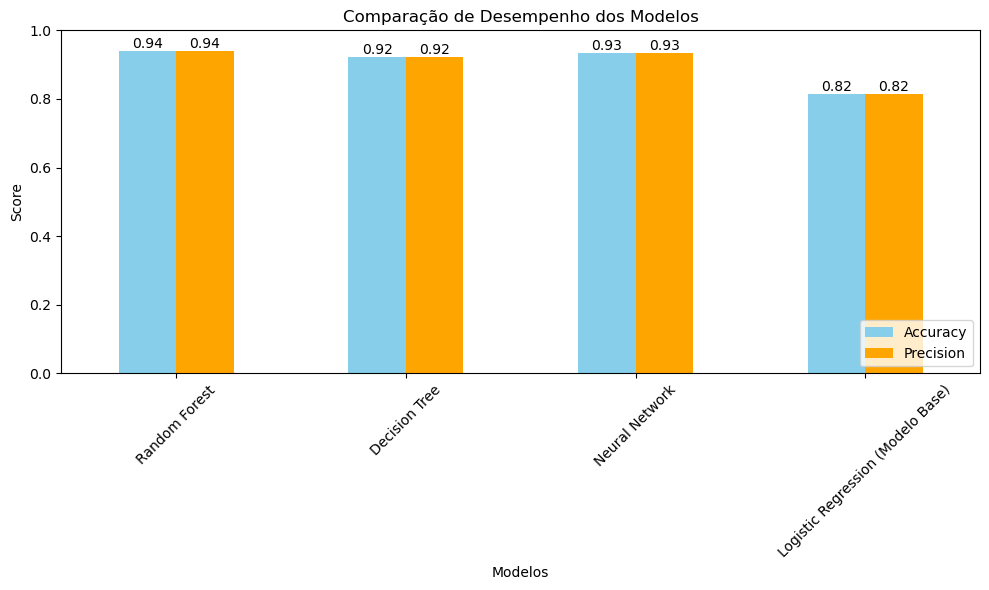

In [135]:
results = []

def evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    # Treinar o modelo (se necessário)
    if hasattr(model, "fit"):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        # Para o modelo personalizado
        y_pred = model  # `model` é o array de previsões já gerado
    
    # Métricas de desempenho
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')  # Para classificação multinomial
    
    # Adicionar resultados
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision
    })

# 1. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model("Random Forest", rf_model, X_train_array, y_train_array, X_test_array, y_test_array)

# 2. Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
evaluate_model("Decision Tree", dt_model, X_train_array, y_train_array, X_test_array, y_test_array)

# 3. Neural Network (MLPClassifier)
nn_model = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42)
evaluate_model("Neural Network", nn_model, X_train_array, y_train_array, X_test_array, y_test_array)

# 4. Logistic Regression (Modelo Base)
# Usar o modelo já treinado anteriormente
y_test_pred_custom = predict(X_test_array, w_out, b_out)  # Previsões já geradas
evaluate_model("Logistic Regression (Modelo Base)", y_test_pred_custom, X_train_array, y_train_array, X_test_array, y_test_array)

# Exibir os resultados
results_df = pd.DataFrame(results)
print("\nResultados Comparativos:")
print(results_df)

# Visualizar os resultados com valores no topo das barras
plt.figure(figsize=(10, 6))
ax = results_df.set_index("Model")[["Accuracy", "Precision"]].plot(kind="bar", figsize=(10, 6), ylim=(0, 1), color=['skyblue', 'orange'])

plt.title("Comparação de Desempenho dos Modelos")
plt.ylabel("Score")
plt.xlabel("Modelos")
plt.xticks(rotation=45)
plt.legend(loc="lower right")

# Adicionar os valores no topo das barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)

plt.tight_layout()
plt.show()

